In [398]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


# Used Functions 

In [399]:
# Assign points based on FTR
def calculate_points(row):
    if row['FTR'] == 'H':  # Home Win
        return 3, 0
    elif row['FTR'] == 'A':  # Away Win
        return 0, 3
    else:  # Draw
        return 1, 1
        
# Calculate last 5 games percentage
def calculate_last_5_percentage(df):
    df['Last5Points'] = df['Points'].rolling(window=5, min_periods=1).sum()
    df['Last5Percentage'] = ((df['Last5Points'] / 15) * 100).round(2)

    return df


# Function to get all games between two teams
def get_all_games(team1, team2, df):
    mask = ((df['HomeTeam'] == team1) & (df['AwayTeam'] == team2)) | ((df['HomeTeam'] == team2) & (df['AwayTeam'] == team1))
    games_between_teams = df[mask]
    games_between_teams = games_between_teams.sort_values(by='Date', ascending=True)
    return games_between_teams

# Function to calculate points based on match results
def calculate_points_based_on_teams(ftr, team, home_team, away_team):
    if ftr == 'H' and team == home_team:
        return 3  # Home team wins
    elif ftr == 'A' and team == away_team:
        return 3  # Away team wins
    elif ftr == 'D':
        return 1  # Draw
    return 0  # Loss


## Load DATSET

# we will use england div0(PL) to train our model

In [400]:
# List of file paths
file_paths = [
    '/kaggle/input/football-data/data/train/england/0/1819.csv',
    '/kaggle/input/football-data/data/train/england/0/1920.csv',
    '/kaggle/input/football-data/data/train/england/0/2021.csv',
    '/kaggle/input/football-data/data/train/england/0/2122.csv'
]

# Load all CSV files into a list of DataFrames
data_frames = [pd.read_csv(file) for file in file_paths]

# Concatenate all DataFrames into one
df = pd.concat(data_frames, ignore_index=True)

# Display the resulting DataFrame
df




,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,22/09/2018,Cardiff,Man City,0,5,A,0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,02/01/2019,Wolves,Crystal Palace,0,2,A,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,28/04/2019,Leicester,Arsenal,3,0,H,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,13/01/2019,Everton,Bournemouth,2,0,H,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,15/09/2018,Tottenham,Liverpool,1,2,A,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,E0,20/04/2022,Chelsea,Arsenal,2,4,A,2,2,D,...,1.72,-0.50,1.95,1.98,1.96,1.96,2.00,1.99,1.92,1.96
1484,E0,22/08/2021,Wolves,Tottenham,0,1,A,0,1,A,...,1.63,0.00,2.03,1.90,2.02,1.91,2.11,1.92,2.02,1.86
1485,E0,23/04/2022,Norwich,Newcastle,0,3,A,0,2,A,...,1.78,0.25,1.97,1.93,2.00,1.93,2.10,1.99,1.96,1.91
1486,E0,26/12/2021,Man City,Leicester,6,3,H,4,0,H,...,3.78,-2.50,1.95,1.95,1.93,1.98,2.09,2.00,1.95,1.93


In [401]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Columns: 124 entries, Div to AvgCAHA
dtypes: float64(101), int64(15), object(8)
memory usage: 1.4+ MB


In [402]:
df.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1477.000000,1488.000000,1488.000000,1488.000000,...,1116.000000,1116.000000,1115.000000,1115.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1105.000000
mean,1.485215,1.264785,0.682124,0.574597,13.549059,11.397177,4.639133,4.024866,10.467070,10.487903,...,2.102070,-0.236559,1.943229,1.962260,1.958584,1.971756,2.014409,2.035125,1.933333,1.952145
std,1.303782,1.216253,0.849322,0.780443,5.635559,5.036536,2.595423,2.392557,3.468601,3.600211,...,0.453826,0.930390,0.112988,0.100685,0.118390,0.105012,0.117904,0.109942,0.106593,0.096055
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.390000,-3.750000,1.650000,1.270000,1.660000,1.300000,1.800000,1.300000,1.700000,1.280000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,8.000000,3.000000,2.000000,8.000000,8.000000,...,1.787500,-0.750000,1.870000,1.890000,1.880000,1.890000,1.930000,1.950000,1.860000,1.870000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,4.000000,10.000000,10.000000,...,2.010000,-0.250000,1.950000,1.970000,1.950000,1.970000,2.010000,2.040000,1.930000,1.950000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,6.000000,5.000000,13.000000,13.000000,...,2.280000,0.250000,2.030000,2.050000,2.040000,2.050000,2.090000,2.120000,2.010000,2.030000
max,9.000000,9.000000,5.000000,5.000000,36.000000,31.000000,15.000000,15.000000,23.000000,25.000000,...,5.770000,3.000000,3.550000,2.200000,3.930000,2.380000,3.950000,2.520000,3.660000,2.240000


## Data cleaing

In [403]:
df = df[['Date','HomeTeam', 'AwayTeam', 'FTR','FTHG','FTAG']]
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by=['Date'])
print(df.isnull().sum())
df.head()

Date        0
HomeTeam    0
AwayTeam    0
FTR         0
FTHG        0
FTAG        0
dtype: int64


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG
159,2018-08-10,Man United,Leicester,H,2,1
207,2018-08-11,Fulham,Crystal Palace,A,0,2
129,2018-08-11,Wolves,Everton,D,2,2
143,2018-08-11,Newcastle,Tottenham,A,1,2
294,2018-08-11,Bournemouth,Cardiff,H,2,0


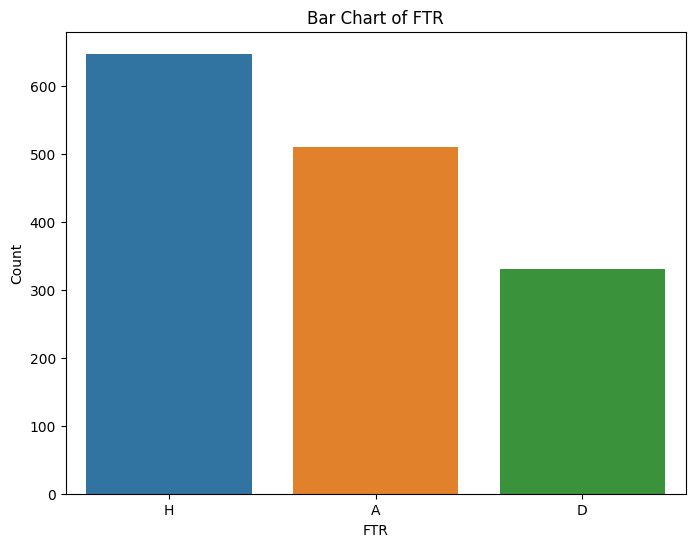

In [404]:
# 2. Bar Chart
plt.figure(figsize=(8, 6))
sns.countplot(x='FTR', data=df)  # Seaborn's countplot is convenient
plt.title('Bar Chart of FTR')
plt.xlabel('FTR')
plt.ylabel('Count')
plt.show()


## Get last 5 games results for each team

In [405]:
# Add points for Home and Away teams
df[['HomePoints', 'AwayPoints']] = df.apply(calculate_points, axis=1, result_type='expand')
# Prepare a combined dataset for all teams
home_data = df[['Date', 'HomeTeam', 'HomePoints']].rename(columns={'HomeTeam': 'Team', 'HomePoints': 'Points'})
away_data = df[['Date', 'AwayTeam', 'AwayPoints']].rename(columns={'AwayTeam': 'Team', 'AwayPoints': 'Points'})
team_data = pd.concat([home_data, away_data], ignore_index=True)
# Sort by team and date
team_data = team_data.sort_values(by=['Team', 'Date'])
# Calculate the last 5 percentage for each team
team_data = team_data.groupby('Team').apply(calculate_last_5_percentage,include_groups=True)
team_data = team_data.reset_index(drop=True)
team_data

,Date,Team,Points,Last5Points,Last5Percentage
0,2018-08-12,Arsenal,0,0.0,0.00
1,2018-08-18,Arsenal,0,0.0,0.00
2,2018-09-02,Arsenal,3,3.0,20.00
3,2018-09-15,Arsenal,3,6.0,40.00
4,2018-09-23,Arsenal,3,9.0,60.00
...,...,...,...,...,...
2971,2022-04-30,Wolves,0,3.0,20.00
2972,2022-05-07,Wolves,1,4.0,26.67
2973,2022-05-11,Wolves,0,1.0,6.67
2974,2022-05-15,Wolves,1,2.0,13.33


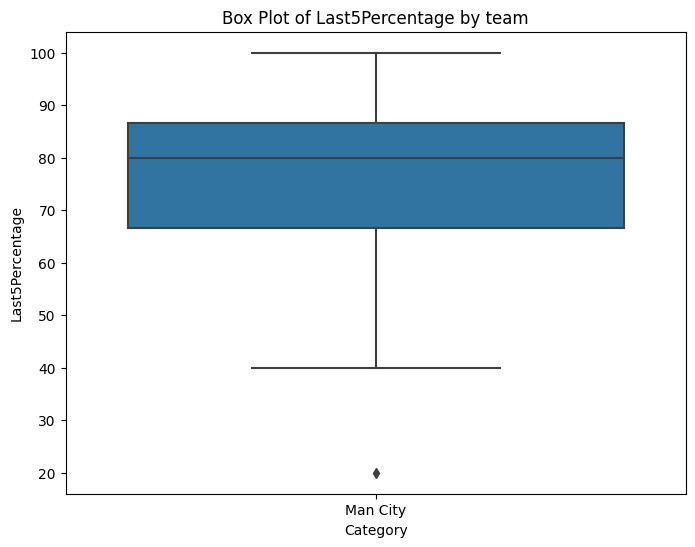

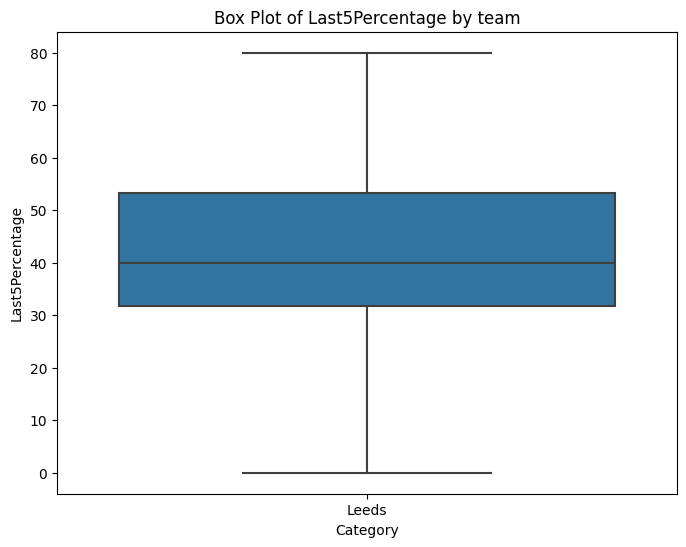

In [406]:
# 5. Box Plot
arsenal_data = team_data.loc[team_data['Team'] == 'Man City']
plt.figure(figsize=(8, 6))
sns.boxplot(x='Team', y='Last5Percentage', data=arsenal_data)
plt.title('Box Plot of Last5Percentage by team')
plt.xlabel('Category')
plt.ylabel('Last5Percentage')
plt.show()


# 5. Box Plot
arsenal_data = team_data.loc[team_data['Team'] == 'Leeds']
plt.figure(figsize=(8, 6))
sns.boxplot(x='Team', y='Last5Percentage', data=arsenal_data)
plt.title('Box Plot of Last5Percentage by team')
plt.xlabel('Category')
plt.ylabel('Last5Percentage')
plt.show()

In [407]:
# Merge back into the original df
df_lg5 = df.merge(team_data[['Date', 'Team', 'Last5Percentage']], 
               left_on=['Date', 'HomeTeam'], 
               right_on=['Date', 'Team'], 
               how='left')

# Rename the column for the home team last 5 percentage
df_lg5 = df_lg5.rename(columns={'Last5Percentage': 'HomeLast5Percentage'})

# Merge for away team last 5 percentage
df_lg5 = df_lg5.merge(team_data[['Date', 'Team', 'Last5Percentage']], 
                left_on=['Date', 'AwayTeam'], 
                right_on=['Date', 'Team'], 
                how='left')

# Rename the column for the away team last 5 percentage
df_lg5 = df_lg5.rename(columns={'Last5Percentage': 'AwayLast5Percentage'})

# Drop the 'Team' column that was added during the merge
df_lg5 = df_lg5.drop(columns=['Team_x','Team_y'])


df_lg5.iloc[:10]


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HomePoints,AwayPoints,HomeLast5Percentage,AwayLast5Percentage
0,2018-08-10,Man United,Leicester,H,2,1,3,0,20.00,0.00
1,2018-08-11,Fulham,Crystal Palace,A,0,2,0,3,0.00,20.00
2,2018-08-11,Wolves,Everton,D,2,2,1,1,6.67,6.67
3,2018-08-11,Newcastle,Tottenham,A,1,2,0,3,0.00,20.00
4,2018-08-11,Bournemouth,Cardiff,H,2,0,3,0,20.00,0.00
5,2018-08-11,Huddersfield,Chelsea,A,0,3,0,3,0.00,20.00
6,2018-08-11,Watford,Brighton,H,2,0,3,0,20.00,0.00
7,2018-08-12,Liverpool,West Ham,H,4,0,3,0,20.00,0.00
8,2018-08-12,Arsenal,Man City,A,0,2,0,3,0.00,20.00
9,2018-08-12,Southampton,Burnley,D,0,0,1,1,6.67,6.67


## Get last games H vs A

In [408]:

# Create a "Team vs Team" dataset
matches = []
for _, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    ftr = row['FTR']

    # Home team record
    matches.append({'Date': row['Date'], 'Team': home_team, 'Opponent': away_team,
                    'Points': calculate_points_based_on_teams(ftr, home_team, home_team, away_team)})
    
    # Away team record
    matches.append({'Date': row['Date'], 'Team': away_team, 'Opponent': home_team,
                    'Points': calculate_points_based_on_teams(ftr, away_team, home_team, away_team)})

# Convert matches into a DataFrame
matches_df = pd.DataFrame(matches)

# Ensure date is in datetime format for sorting
matches_df['Date'] = pd.to_datetime(matches_df['Date'])

# Sort by team, opponent, and date
matches_df = matches_df.sort_values(by=['Team', 'Opponent', 'Date'])

# Calculate rolling points for the last 3 games each team played against each opponent
matches_df['RollingPoints'] = matches_df.groupby(['Team', 'Opponent'])['Points'] \
    .rolling(window=3, min_periods=1).sum().reset_index(level=[0, 1], drop=True)

# Calculate percentage points out of 9
matches_df['Percentage'] = ((matches_df['RollingPoints'] / 9) * 100).round(2)

matches_df

,Date,Team,Opponent,Points,RollingPoints,Percentage
854,2019-09-22,Arsenal,Aston Villa,3,3.0,33.33
1463,2020-07-21,Arsenal,Aston Villa,0,3.0,33.33
1634,2020-11-08,Arsenal,Aston Villa,0,3.0,33.33
1917,2021-02-06,Arsenal,Aston Villa,0,0.0,0.00
2388,2021-10-22,Arsenal,Aston Villa,3,3.0,33.33
...,...,...,...,...,...,...
1323,2020-06-20,Wolves,West Ham,3,9.0,100.00
1535,2020-09-27,Wolves,West Ham,0,6.0,66.67
2072,2021-04-05,Wolves,West Ham,0,3.0,33.33
2456,2021-11-20,Wolves,West Ham,3,3.0,33.33


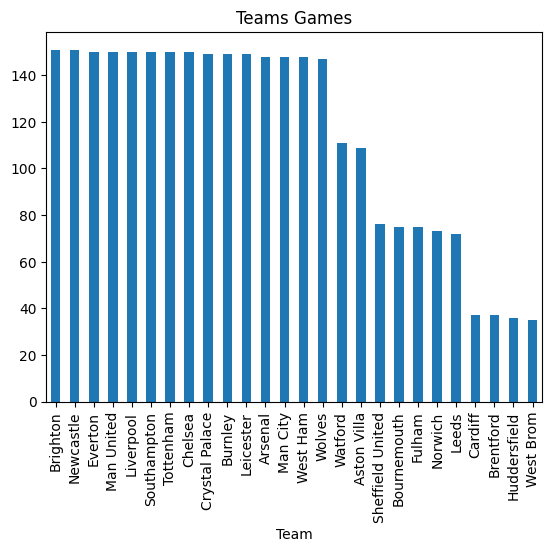

In [409]:
matches_df['Team'].value_counts().plot(kind='bar', title='Teams Games')
plt.show()

In [410]:
# Merge HomeTeam rolling stats
df_lg3ha = df.merge(
    matches_df[['Date', 'Team', 'Opponent', 'RollingPoints', 'Percentage']],
    left_on=['Date', 'HomeTeam', 'AwayTeam'],
    right_on=['Date', 'Team', 'Opponent'],
    how='left'
).rename(columns={'RollingPoints': 'HomeRollingPoints', 'Percentage': 'HomeLast3HA'})

# Merge AwayTeam rolling stats
df_lg3ha = df_lg3ha.merge(
    matches_df[['Date', 'Team', 'Opponent', 'RollingPoints', 'Percentage']],
    left_on=['Date', 'AwayTeam', 'HomeTeam'],
    right_on=['Date', 'Team', 'Opponent'],
    how='left'
).rename(columns={'RollingPoints': 'AwayRollingPoints', 'Percentage': 'AwayLast3HA'})

# Drop unnecessary columns after merging
df_lg3ha = df_lg3ha.drop(columns=['Team_x', 'Opponent_x', 'Team_y', 'Opponent_y'])

In [411]:
# Filter rows where 'HomeTeam' or 'AwayTeam' is 'Man City' or 'Leicester'
team = df_lg3ha[
    ((df_lg3ha['HomeTeam'] == 'Man City') | (df_lg3ha['HomeTeam'] == 'Leicester')) &
    ((df_lg3ha['AwayTeam'] == 'Man City') | (df_lg3ha['AwayTeam'] == 'Leicester'))
]


print("exemple of df_lg3ha")
team

exemple of df_lg3ha


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HomePoints,AwayPoints,HomeRollingPoints,HomeLast3HA,AwayRollingPoints,AwayLast3HA
181,2018-12-26,Leicester,Man City,H,2,1,3,0,3.0,33.33,0.0,0.00
362,2019-05-06,Man City,Leicester,H,1,0,3,0,3.0,33.33,3.0,33.33
543,2019-12-21,Man City,Leicester,H,3,1,3,0,6.0,66.67,3.0,33.33
631,2020-02-22,Leicester,Man City,A,0,1,0,3,0.0,0.00,9.0,100.00
766,2020-09-27,Man City,Leicester,A,2,5,0,3,6.0,66.67,3.0,33.33
1030,2021-04-03,Leicester,Man City,A,0,2,0,3,3.0,33.33,6.0,66.67
1147,2021-09-11,Leicester,Man City,A,0,1,0,3,3.0,33.33,6.0,66.67
1286,2021-12-26,Man City,Leicester,H,6,3,3,0,9.0,100.00,0.0,0.00


In [412]:
df_lg3ha.head()

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HomePoints,AwayPoints,HomeRollingPoints,HomeLast3HA,AwayRollingPoints,AwayLast3HA
0,2018-08-10,Man United,Leicester,H,2,1,3,0,3.0,33.33,0.0,0.00
1,2018-08-11,Fulham,Crystal Palace,A,0,2,0,3,0.0,0.00,3.0,33.33
2,2018-08-11,Wolves,Everton,D,2,2,1,1,1.0,11.11,1.0,11.11
3,2018-08-11,Newcastle,Tottenham,A,1,2,0,3,0.0,0.00,3.0,33.33
4,2018-08-11,Bournemouth,Cardiff,H,2,0,3,0,3.0,33.33,0.0,0.00


## merge both datasets (lg3ha and lg5)

In [413]:
# Find columns in dataset2 that are not in dataset1
new_columns = [col for col in df_lg3ha.columns if col not in df_lg5.columns]

# Merge datasets by adding only new columns from dataset2
merged_data = df_lg5.merge(df_lg3ha[['Date', 'HomeTeam', 'AwayTeam'] + new_columns], 
                              on=['Date', 'HomeTeam', 'AwayTeam'], 
                              how='left')
merged_data = merged_data.drop(columns=['AwayRollingPoints','HomeRollingPoints'])
# Initialize LabelEncoders for hometeam and awayteam
home_team_encoder = LabelEncoder()
away_team_encoder = LabelEncoder()

# Encode hometeam and awayteam
merged_data['HomeTeam_encoded'] = home_team_encoder.fit_transform(merged_data['HomeTeam'])
merged_data['AwayTeam_encoded'] = away_team_encoder.fit_transform(merged_data['AwayTeam'])
merged_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HomePoints,AwayPoints,HomeLast5Percentage,AwayLast5Percentage,HomeLast3HA,AwayLast3HA,HomeTeam_encoded,AwayTeam_encoded
0,2018-08-10,Man United,Leicester,H,2,1,3,0,20.00,0.00,33.33,0.00,16,13
1,2018-08-11,Fulham,Crystal Palace,A,0,2,0,3,0.00,20.00,0.00,33.33,10,8
2,2018-08-11,Wolves,Everton,D,2,2,1,1,6.67,6.67,11.11,11.11,25,9
3,2018-08-11,Newcastle,Tottenham,A,1,2,0,3,0.00,20.00,0.00,33.33,17,21
4,2018-08-11,Bournemouth,Cardiff,H,2,0,3,0,20.00,0.00,33.33,0.00,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2022-05-22,Burnley,Newcastle,A,1,2,0,3,26.67,60.00,0.00,100.00,5,17
1484,2022-05-22,Crystal Palace,Man United,H,1,0,3,0,66.67,26.67,44.44,44.44,8,16
1485,2022-05-22,Man City,Aston Villa,H,3,2,3,0,86.67,33.33,100.00,0.00,15,1
1486,2022-05-22,Leicester,Southampton,H,4,1,3,0,66.67,6.67,55.56,22.22,13,20


## Train Random Forest model

In [414]:
# Encode target variable (FTR)
label_encoder = LabelEncoder()
merged_data['FTR'] = label_encoder.fit_transform(merged_data['FTR'])  # Maps H->2, D->1, A->0
# Select features and target
features = ['HomeTeam_encoded','AwayTeam_encoded','HomeLast5Percentage', 'AwayLast5Percentage', 'HomeLast3HA', 'AwayLast3HA']
X = merged_data[features]
Y = merged_data['FTR']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.81
Confusion Matrix:


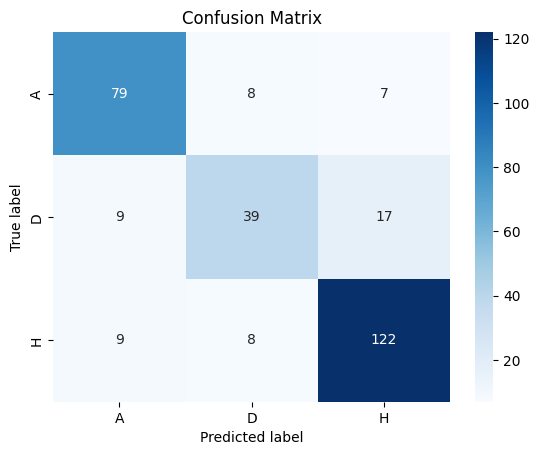

Classification Report:
              precision    recall  f1-score   support

           A       0.81      0.84      0.83        94
           D       0.71      0.60      0.65        65
           H       0.84      0.88      0.86       139

    accuracy                           0.81       298
   macro avg       0.79      0.77      0.78       298
weighted avg       0.80      0.81      0.80       298

Cross-validation Accuracy: 0.80 ± 0.07


In [415]:
# Predict and evaluate
y_pred = model.predict(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# 3. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 5. Cross-Validation
cross_val_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.2f} ± {cross_val_scores.std():.2f}")

## Test model (next pl sesion)

In [416]:
new_data = pd.read_csv('/kaggle/input/football-data/data/test/england/0/2223.csv')
new_data = new_data[['Date','HomeTeam','AwayTeam']]
new_data['Date'] = pd.to_datetime(new_data['Date'], format='%d/%m/%Y')
new_data = new_data.sort_values(by='Date', ascending=True)
new_data = new_data.iloc[:10] 
new_data

,Date,HomeTeam,AwayTeam
0,2022-08-05,Crystal Palace,Arsenal
1,2022-08-06,Fulham,Liverpool
2,2022-08-06,Bournemouth,Aston Villa
3,2022-08-06,Leeds,Wolves
4,2022-08-06,Newcastle,Nott'm Forest
5,2022-08-06,Tottenham,Southampton
6,2022-08-06,Everton,Chelsea
7,2022-08-07,Leicester,Brentford
8,2022-08-07,Man United,Brighton
9,2022-08-07,West Ham,Man City


In [417]:
# Function to get the most recent data
def get_recent_data(home_team, away_team, df):
    match_data = df[(df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)].sort_values('Date', ascending=False)
    if not match_data.empty:
        return match_data.iloc[0][['HomeLast5Percentage', 'AwayLast5Percentage', 'HomeLast3HA', 'AwayLast3HA','HomeTeam_encoded','AwayTeam_encoded']]
    return pd.Series([None, None, None, None, None, None], index=['HomeLast5Percentage', 'AwayLast5Percentage', 'HomeLast3HA', 'AwayLast3HA','HomeTeam_encoded','AwayTeam_encoded'])

# Apply the function to new_data
new_data[['HomeLast5Percentage', 'AwayLast5Percentage', 'HomeLast3HA', 'AwayLast3HA','HomeTeam_encoded','AwayTeam_encoded']] = new_data.apply(lambda row: get_recent_data(row['HomeTeam'], row['AwayTeam'], merged_data), axis=1)
new_data.dropna(subset='HomeLast5Percentage', inplace=True)
new_data['HomeTeam_encoded'] = pd.to_numeric(new_data['HomeTeam_encoded'], errors='coerce').astype('Int64')
new_data['AwayTeam_encoded'] = pd.to_numeric(new_data['AwayTeam_encoded'], errors='coerce').astype('Int64')
new_data

,Date,HomeTeam,AwayTeam,HomeLast5Percentage,AwayLast5Percentage,HomeLast3HA,AwayLast3HA,HomeTeam_encoded,AwayTeam_encoded
0,2022-08-05,Crystal Palace,Arsenal,73.33,60.00,44.44,44.44,8,0
1,2022-08-06,Fulham,Liverpool,26.67,60.00,11.11,77.78,10,14
2,2022-08-06,Bournemouth,Aston Villa,40.00,46.67,66.67,0.00,2,1
3,2022-08-06,Leeds,Wolves,33.33,66.67,11.11,77.78,12,25
5,2022-08-06,Tottenham,Southampton,46.67,53.33,44.44,44.44,21,20
6,2022-08-06,Everton,Chelsea,46.67,46.67,44.44,44.44,9,7
7,2022-08-07,Leicester,Brentford,60.00,40.00,66.67,0.00,13,3
8,2022-08-07,Man United,Brighton,73.33,40.00,100.00,0.00,16,4
9,2022-08-07,West Ham,Man City,33.33,86.67,11.11,77.78,24,15


In [418]:
features = ['HomeTeam_encoded','AwayTeam_encoded','HomeLast5Percentage', 'AwayLast5Percentage', 'HomeLast3HA', 'AwayLast3HA']
X_new = new_data[features]
y_new = model.predict(X_new)
y_new # Maps H->2, D->1, A->0

array([2, 1, 2, 0, 0, 2, 2, 2, 0])

In [419]:
# Create a mapping from encoded values back to team names
team_encoding = pd.concat([new_data[['HomeTeam', 'HomeTeam_encoded']].rename(columns={'HomeTeam': 'Team', 'HomeTeam_encoded': 'Team_encoded'}),
                           new_data[['AwayTeam', 'AwayTeam_encoded']].rename(columns={'AwayTeam': 'Team', 'AwayTeam_encoded': 'Team_encoded'})]).drop_duplicates().set_index('Team_encoded')['Team'].to_dict()

# Map the encoded team names back to real names in new_data
new_data['HomeTeam'] = new_data['HomeTeam_encoded'].map(team_encoding)
new_data['AwayTeam'] = new_data['AwayTeam_encoded'].map(team_encoding)

# Create a mapping for the predictions
result_mapping = {2: 'H', 1: 'D', 0: 'A'}
predicted_results = [result_mapping[pred] for pred in y_new]

# Add the predictions to the DataFrame
new_data['PredictedResult'] = predicted_results


import matplotlib.pyplot as plt

# Count the occurrences of each predicted result
result_counts = new_data['PredictedResult'].value_counts()
new_data[['Date', 'HomeTeam', 'AwayTeam', 'PredictedResult']]

,Date,HomeTeam,AwayTeam,PredictedResult
0,2022-08-05,Crystal Palace,Arsenal,H
1,2022-08-06,Fulham,Liverpool,D
2,2022-08-06,Bournemouth,Aston Villa,H
3,2022-08-06,Leeds,Wolves,A
5,2022-08-06,Tottenham,Southampton,A
6,2022-08-06,Everton,Chelsea,H
7,2022-08-07,Leicester,Brentford,H
8,2022-08-07,Man United,Brighton,H
9,2022-08-07,West Ham,Man City,A


In [420]:
# Predict probabilities for each class
y_new_proba = model.predict_proba(X_new)
# Create a DataFrame to store the probabilities
probability_df = pd.DataFrame(y_new_proba, columns=['Away_Win_Prob', 'Draw_Prob', 'Home_Win_Prob'])

# Concatenate the probabilities with the original new_data DataFrame
new_data = pd.concat([new_data.reset_index(drop=True), probability_df.reset_index(drop=True)], axis=1)


# Create a mapping for the predictions (same as before)
result_mapping = {2: 'H', 1: 'D', 0: 'A'}
predicted_results = [result_mapping[pred] for pred in y_new]

# Add the predictions to the DataFrame
new_data['PredictedResult'] = predicted_results

new_data[['Date', 'HomeTeam', 'AwayTeam', 'PredictedResult','Away_Win_Prob', 'Draw_Prob', 'Home_Win_Prob']]

,Date,HomeTeam,AwayTeam,PredictedResult,Away_Win_Prob,Draw_Prob,Home_Win_Prob
0,2022-08-05,Crystal Palace,Arsenal,H,0.20,0.04,0.76
1,2022-08-06,Fulham,Liverpool,D,0.25,0.75,0.00
2,2022-08-06,Bournemouth,Aston Villa,H,0.00,0.01,0.99
3,2022-08-06,Leeds,Wolves,A,0.49,0.49,0.02
4,2022-08-06,Tottenham,Southampton,A,0.85,0.05,0.10
5,2022-08-06,Everton,Chelsea,H,0.17,0.16,0.67
6,2022-08-07,Leicester,Brentford,H,0.00,0.00,1.00
7,2022-08-07,Man United,Brighton,H,0.00,0.00,1.00
8,2022-08-07,West Ham,Man City,A,0.78,0.22,0.00
